In [113]:
import numpy as np
import pandas as pd
from DataProcessing import Data

# 1. Get Data 

## 1.1. Get Data from folder

In [114]:
d = Data()
d.get_index_names()

S&P 500: ['AAPL', 'ORCL', 'GOOGL', 'AMZN', 'BK', 'LIFE', 'T', 'XOM']
 VN: ['VHM', 'CTR', 'FPT', 'MBB']


['AAPL',
 'ORCL',
 'GOOGL',
 'AMZN',
 'BK',
 'LIFE',
 'T',
 'XOM',
 'VHM',
 'CTR',
 'FPT',
 'MBB']

In [115]:
chosen_index = 'VHM'

In [116]:
d.preprocess(chosen_index)

Processing VHM.csv


Saved VHM data at data/processed/VHM.csv


In [117]:
df = d.get_data(chosen_index)

In [118]:
df.head

<bound method NDFrame.head of            Date    Close   Volume        RSI        MFI           EMA  \
0    2019-04-01  92400.0   334480  85.102948  46.916858  91671.458559   
1    2019-04-02  92200.0   359690  60.686970  38.602377  91741.930752   
2    2019-04-03  92000.0   281350  55.712418  34.159414  91776.339985   
3    2019-04-04  92000.0   489550  51.750921  45.601086  91806.161320   
4    2019-04-05  92600.0   454260  48.898215  42.104667  91912.006477   
..          ...      ...      ...        ...        ...           ...   
723  2022-02-23  79400.0  2850000  46.858287  37.328201  79900.499755   
724  2022-02-24  78600.0  5284300  45.414589  36.375513  79727.099787   
725  2022-02-25  78300.0  2693300  46.900771  34.511452  79536.819816   
726  2022-02-28  77500.0  2837300  46.144075  25.960529  79265.243840   
727  2022-03-01  78000.0  2459200  45.032803  31.291963  79096.544662   

            SO          MACD  Next Day Price  
0    57.647059  92340.391242         92200.0  

In [119]:
df.columns

Index(['Date', 'Close', 'Volume', 'RSI', 'MFI', 'EMA', 'SO', 'MACD',
       'Next Day Price'],
      dtype='object')

# 2. Train model

In [120]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  train_test_split

In [121]:
X = df[df.columns[1:8]].values
Y = df[df.columns[8]].values

## 2.1. Split data

### 2.1.2. Unchronologically

In [122]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=37)

### 2.1.2. Chronologically

In [123]:
TRAIN_PERCENT = 0.8
train_size = int(TRAIN_PERCENT*len(X))

X_train = X[0:train_size]
Y_train = Y[0:train_size]
X_test = X[train_size:len(X)]
Y_test = Y[train_size:len(Y)]

## 2.2. Train model

In [124]:
model = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
model.fit(X_train,Y_train)
model.score(X_test,Y_test)

0.940120893874966

# Evaluation

In [125]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error

oob_score = model.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions = model.predict(X_test)

mse = mean_squared_error(Y_test, predictions)
# print(f'Mean Squared Error: {mse}')

r2 = r2_score(Y_test, predictions)
print(f'R-squared: {r2}')

rmse = root_mean_squared_error(Y_test, predictions)
print(f'Root Mean Squared Error: {rmse}')

mape = mean_absolute_percentage_error(Y_test, predictions)
print(f'Mean Absolute Percentage Error: {mape}')


Out-of-Bag Score: 0.9775684498745391
R-squared: 0.940120893874966
Root Mean Squared Error: 2827.8411430196556
Mean Absolute Percentage Error: 0.01615861025268708


## Plot Result

In [126]:
import matplotlib.pyplot as plt

In [127]:
Y_predict = model.predict(X_test)

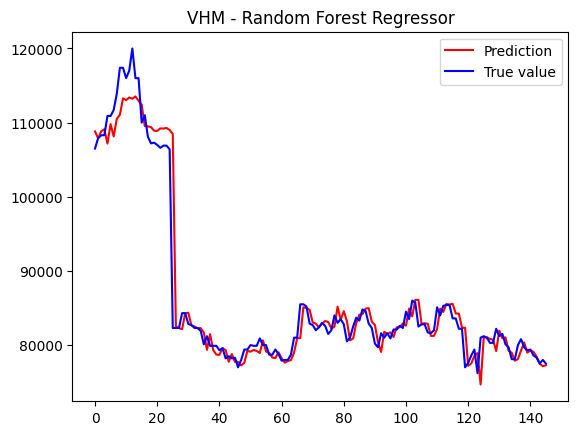

In [128]:
plt.plot(Y_predict,color='red',label='Prediction')
plt.plot(Y_test,color='blue',label='True value')
plt.legend(loc='upper right')
plt.title(f'{chosen_index} - Random Forest Regressor')
plt.show()